# Measuring Word Similarity with BERT (English Language Public Domain Poems)

By [The BERT for Humanists](https://melaniewalsh.github.io/BERT-for-Humanists/) Team

How can we measure the similarity of words in a collection of texts? For example, how similar are the words "nature" and "science" in a collection of 16th-20th century English language poems? Do 20th-century poets use the word "science" differently than 16th-century poets? Can we map all the different uses and meanings of the word "nature"?

The short answer is: yes! We can explore all of these questions with BERT, a natural language processing model that has revolutionized the field.

BERT turns words or tokens into vectors — essentially, a list of numbers in a coordinate system (x, y). We can then use the geometric similarity between these resulting vectors as a way to represent varying types of similarity between words.

## In This Notebook
In this Colab notebook, we will specifically analyze a collection of poems scraped from [Public-Domain-Poetry.com](http://public-domain-poetry.com/) with the [DistilBert model](https://huggingface.co/transformers/model_doc/distilbert.html) and the HuggingFace Python library. DistilBert is a smaller — yet still powerful! — version of BERT. By using the rich representations of words that BERT produces, we will then explore the multivalent meanings of particular words in context and over time.

We hope this notebook will help illustrate how BERT works, how well it works, and how you might use BERT to explore the similarity of words in a collection of texts. It is surprising, for example, that BERT works as well as it does, without any fine-tuning, on poems that were published hundreds of years before the text data it was trained on (Wikiepdia pages and self-published novels). 

But we also hope that these results will expose some of the limitations and challenges of BERT. We have to disregard poetic line breaks, for example, and we see that BERT has trouble with antiquated words like "thine," which don't show up in its contemporary vocabulary.

In [ ]:
#@title BERT Word Vectors: A Preview { display-mode: "form" }
#@title: Hover
import pandas as pd
import altair as alt

url = "https://raw.githubusercontent.com/melaniewalsh/BERT-4-Humanists/main/data/bert-word-nature.csv"
df = pd.read_csv(url, encoding='utf-8')

search_keywords = ['nature', 'science', 'religion', 'art']
color_by = 'word'

alt.Chart(df, title=f"Word Similarity: {', '.join(search_keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    href="link",
    tooltip=['title', 'word', 'poem_title', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

The plot above displays a preview of our later results. This is what we're working toward!

You can hover over each point to see the instance of each word in context. If you press `Shift` and click on a point, you will be taken to the original poem on Public-Domain-Poetry.com. Try it out!

## **Import necessary Python libraries and modules**

Ok enough introduction! Let's get started.

To use the HuggingFace [`transformers` Python library](https://huggingface.co/transformers/installation.html), we first need to install it with `pip`.

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.3MB 12.8MB/s 
     |████████████████████████████████| 3.3MB 48.8MB/s 
     |████████████████████████████████| 901kB 51.6MB/s 


Then we will import the DistilBertModel and DistilBertTokenizerFast from the Hugging Face `transformers` library. We will also import a handful of other Python libraries and modules.

In [ ]:
# For BERT
from transformers import DistilBertTokenizerFast, DistilBertModel

# For data manipulation and analysis
import pandas as pd
pd.options.display.max_colwidth = 200
import numpy as np
from sklearn.decomposition import PCA

# For interactive data visualization
import altair as alt

## **Load text dataset**

Our dataset contains around ~30 thousand poems scraped from  http://public-domain-poetry.com/. This website hosts a curated collection of poems that have fallen out of copyright, which makes them easier for us to share on the web. 
You can find the data in our [GitHub repository](https://github.com/melaniewalsh/BERT-4-Humanists/blob/main/data/public-domain-poetry.csv).

We don't have granular date information about when each poem was published, but we do know the birth dates of most of our authors, which we've used to loosely categorize the poems by time period. The poems in our data range from the Middle Ages to the 20th Century, but most come from the 19th Century. The data features both well-known authors — William Wordsworth, Emily Elizabeth Dickinson, Paul Laurence Dunbar, Walt Whitman, Shakespeare — as well as less well-known authors.

Below we will use the Python library `pandas` to read in our CSV file of poems. It is convenient (especially for Colab notebooks) that `pandas` allows you to read in files directly from the web.

To be clear, however, knowledge of `pandas` is not necessary to use BERT. This is simply how we've chosen to load our data. All you really need  is a list of texts (poems, passages, etc.). You can create this list however you are most comfortable.

In [ ]:
url = "https://raw.githubusercontent.com/melaniewalsh/BERT-4-Humanists/main/data/public-domain-poetry.csv"

poetry_df = pd.read_csv(url, encoding='utf-8')
# Show 5 random rows
poetry_df.sample(5)

,author,title,text,lifespan,birth_year,death_year,link,period
7104,Fannie Isabelle Sherrick,Two Pictures,"A beautiful form and a beautiful face,\r\nA winsome bride and a woman's grace,\r\nSo fair and sweet it were heaven indeed\r\nFor man to follow where she would lead.\n\r\nA web of lace and a jewele...",NaN,NaN,NaN,http://public-domain-poetry.com/fannie-isabelle-sherrick/two-pictures-31613,NaN
2471,Arthur Hugh Clough,Mari Magno or Tales on Board1,"A youth was I. An elder friend with me,\r\n'Twas in September o'er the autumnal sea\r\nWe went; the wide Atlantic ocean o'er\r\nTwo amongst many the strong steamer bore.\r\nDelight it was to feel ...","January 1, 1819-November 13, 1861",1819.0,1861.0,http://public-domain-poetry.com/arthur-hugh-clough/mari-magno-or-tales-on-board-7455,19th Century
21807,Robert Lee Frost,The Flood,"Blood has been harder to dam back than water.\r\nJust when we think we have it impounded safe\r\nBehind new barrier walls (and let it chafe!),\r\nIt breaks away in some new kind of slaughter.\r\nW...","March 26, 1874-January 29, 1963",1874.0,1963.0,http://public-domain-poetry.com/robert-lee-frost/flood-1167,20th Century
9823,"Henry John Newbolt, Sir",The Last Word,"Before the April night was late\r\nA rider came to the castle gate;\r\nA rider breathing human breath,\r\nBut the words he spoke were the words of Death.\n\r\n""Greet you well from the King our lor...",6 June 1862-19 April 1938,1862.0,1938.0,http://public-domain-poetry.com/sir-henry-john-newbolt/last-word-27900,19th Century
24075,Thomas Gent,Sonnet. To Melancholy,"To thy unhappy courts a lonely guest\r\nI come, corroding Melancholy, where,\r\nSequester'd from the world, this woe-worn breast\r\nMay yet indulge a solitary tear!\r\nFor what should cheer the wr...",1780 - ?,1780.0,NaN,http://public-domain-poetry.com/thomas-gent/sonnet-to-melancholy-16275,19th Century


In [ ]:
#@title *Click here to see how you might load a dataset from your own computer*
#from google.colab import files
#uploaded = files.upload()

Let's check to see how many poems are in this dataset:

In [ ]:
len(poetry_df)

31080

Let's check to see which authors show up the most in this dataset to get a sense of its contours:

In [ ]:
poetry_df['author'].value_counts()[:20]

Robert Herrick                   1464
Madison Julius Cawein            1345
William Wordsworth                963
Thomas Moore                      853
Thomas Hardy                      655
Rudyard Kipling                   638
Robert Burns                      499
John Greenleaf Whittier           481
Algernon Charles Swinburne        461
Emily Elizabeth Dickinson         447
Paul Laurence Dunbar              417
John Clare                        382
William Butler Yeats              378
Francesco Petrarca (Petrarch)     375
Paul Cameron Brown                341
Walt Whitman                      338
Edgar Lee Masters                 331
Percy Bysshe Shelley              330
Walter De La Mare                 329
Oliver Wendell Holmes             329
Name: author, dtype: int64

Let's check to see what time periods show up the most in this dataset to get a sense of its contours:

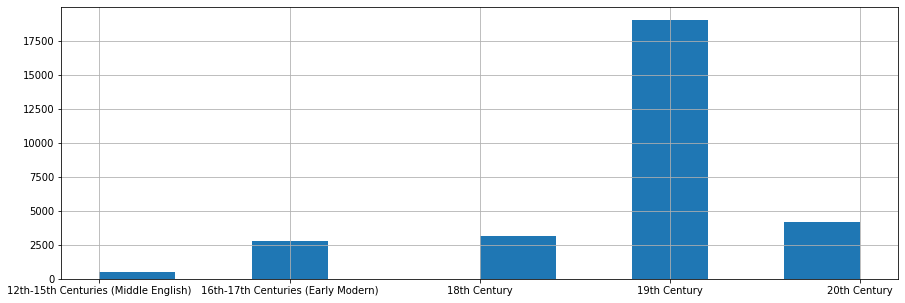

In [ ]:
# Sort values, then create a histogram, and define the size of the figure
poetry_df['period'].sort_values().hist(figsize=(15, 5))

## **Sample text dataset**

Though we wish we could analyze all the poems in this data, Colab tends to crash if we try to use more than 4-5,000 poems —  even with DistilBert, the smaller version of BERT. This is an important limitation to keep in mind. If you'd like to use more text data, you might consider upgrading to a paid version of Colab (with more memory or GPUs) or using a compute cluster.

To reduce the number of poems, we will take a random sample of 1,000 poems from four different time periods: the 20th Century, 19th Century, 18th Century, and the Early Modern period.

In [ ]:
# Filter the DataFrame for only a given time period, then randomly sample 1000 rows
nineteenth_sample = poetry_df[poetry_df['period'] == '19th Century'].sample(1000)
twentieth_sample = poetry_df[poetry_df['period'] == '20th Century'].sample(1000)
eighteenth_sample = poetry_df[poetry_df['period'] == '18th Century'].sample(1000)
sixteenth_sample = poetry_df[poetry_df['period'] == '16th-17th Centuries (Early Modern)'].sample(1000)

In [ ]:
# Merge these random samples into a new DataFrame
poetry_df = pd.concat([sixteenth_sample, eighteenth_sample, twentieth_sample, nineteenth_sample])

In [ ]:
poetry_df['period'].value_counts()

16th-17th Centuries (Early Modern)    1000
20th Century                          1000
19th Century                          1000
18th Century                          1000
Name: period, dtype: int64

Finally, let's make a list of poems from our Pandas DataFrame.

In [ ]:
poetry_texts = poetry_df['text'].tolist()

Let's examine a poem in our dataset:

In [ ]:
len(poetry_texts)

4000

In [ ]:
print(poetry_texts[0])

When to thy porch I come and ravish'd see
The state of poets there attending thee,
Those bards and I, all in a chorus sing:
We are thy prophets, Porter, thou our king.


## **Encode/tokenize text data for BERT**

Next we need to transform our poems into a format that BERT (via Huggingface) will understand. This is called *encoding* or *tokenizing* the data.

We will tokenize the poems with the `tokenizer()` from HuggingFace's `DistilBertTokenizerFast`. Here's what the `tokenizer()` will do:

1. Truncate the texts if they're more than 512 tokens or pad them if they're fewer than 512 tokens. If a word is not in BERT's vocabulary, it will be broken up into smaller "word pieces," demarcated by a `##`.

2. Add in special tokens to help BERT:
    - [CLS] — Start token of every document
    - [SEP] — Separator between each sentence 
    - [PAD] — Padding at the end of the document as many times as necessary, up to 512 tokens
    - &#35;&#35; — Start of a "word piece" 

Here we will load `DistilBertTokenizerFast` from HuggingFace library, which will help us transform and encode the texts so they can be used with BERT.

In [ ]:
from transformers import DistilBertTokenizerFast

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

The `tokenizer()` will break word tokens into word pieces, truncate to 512 tokens, and add padding and special BERT tokens.

In [ ]:
tokenized_poems = tokenizer(poetry_texts, truncation=True, padding=True, return_tensors="pt")

Let's examine the first tokenized poem. We can see that the special BERT tokens have been inserted where necessary.

In [ ]:
' '.join(tokenized_poems[0].tokens)

"[CLS] when to thy porch i come and ravi ##sh ' d see the state of poets there attending thee , those bard ##s and i , all in a chorus sing : we are thy prophets , porter , thou our king . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

<br><br>

## **Load pre-trained BERT model**

Here we will load a pre-trained BERT model. To speed things up we will use a GPU, but using GPU involves a few extra steps.
The command `.to("cuda")` moves data from regular memory to the GPU's memory.




In [ ]:
from transformers import DistilBertModel

In [ ]:
model = DistilBertModel.from_pretrained('distilbert-base-uncased').to("cuda")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## **Get BERT word embeddings for each document in a collection**

To get word embeddings for all the words in our collection, we will use a `for` loop.

For each poem in our list `poetry_texts`, we will tokenize the poem, and we will extract the vocabulary word ID for each word/token in the poem (to use for later reference). Then we will run the tokenized poem through the BERT model and extract the vectors for each word/token in the poem.

We thus create two big lists for all the poems in our collection — `doc_word_ids` and `doc_word_vectors`.

In [ ]:
# List of vocabulary word IDs for all the words in each document (aka each poem)
doc_word_ids = []
# List of word vectors for all the words in each document (aka each poem)
doc_word_vectors = []

# Below we will slice our poem to ignore the first (0th) and last (-1) special BERT tokens
start_of_words = 1
end_of_words = -1

# Below we will index the 0th or first document, which will be the only document, since we're analzying one poem at a time
first_document = 0

for i, poem in enumerate(poetry_texts):
  
    # Here we tokenize each poem with the DistilBERT Tokenizer
    inputs = tokenizer(poem, return_tensors="pt", truncation=True, padding=True)

    # Here we extract the vocabulary word ids for all the words in the poem (the first or 0th document, since we only have one document)
    # We ignore the first and last special BERT tokens
    # We also convert from a Pytorch tensor to a numpy array
    doc_word_ids.append(inputs.input_ids[first_document].numpy()[start_of_words:end_of_words])

    # Here we send the tokenized poems to the GPU
    # The model is already on the GPU, but this poem isn't, so we send it to the GPU
    inputs.to("cuda")
    # Here we run the tokenized poem through the DistilBERT model
    outputs = model(**inputs)

    # We take every element from the first or 0th document, from the 2nd to the 2nd to last position
    # Grabbing the last layer is one way of getting token vectors. There are different ways to get vectors with different pros and cons
    doc_word_vectors.append(outputs.last_hidden_state[first_document,start_of_words:end_of_words,:].detach().cpu().numpy())


Confirm that we have the same number of documents for both the tokens and the vectors:

In [ ]:
len(doc_word_ids), len(doc_word_vectors)

(4000, 4000)

In [ ]:
doc_word_ids[0], doc_word_vectors[0]

(array([ 2043,  2000, 15177,  7424,  1045,  2272,  1998, 16806,  4095,
         1005,  1040,  2156,  1996,  2110,  1997,  9736,  2045,  7052,
        14992,  1010,  2216, 22759,  2015,  1998,  1045,  1010,  2035,
         1999,  1037,  7165,  6170,  1024,  2057,  2024, 15177, 23172,
         1010,  8716,  1010, 15223,  2256,  2332,  1012]),
 array([[-0.4132233 ,  0.23495656,  0.352908  , ..., -0.14345758,
          0.05616523, -0.09410256],
        [ 0.24176075,  0.11400958,  0.4033177 , ..., -0.11924279,
          0.32554218,  0.0207546 ],
        [ 0.16030155,  0.658571  ,  0.46676674, ..., -0.18463217,
          0.5922374 ,  0.14052588],
        ...,
        [ 0.3989723 ,  0.69029903,  0.34327012, ..., -0.14313976,
          0.24893996, -0.24432279],
        [ 0.05397775,  0.2744551 ,  0.15093248, ..., -0.0344663 ,
          0.01873861, -0.4427815 ],
        [ 0.6110248 ,  0.45612204, -0.4342807 , ...,  0.1745699 ,
         -0.42640686, -0.60329074]], dtype=float32))

## **Concatenate all word IDs/vectors for all documents**

Each element of these lists contains all the tokens/vectors for one document. But we want to concatenate them into two giant collections.

In [ ]:
all_word_ids = np.concatenate(doc_word_ids)
all_word_vectors = np.concatenate(doc_word_vectors, axis=0)

We want to make comparisons between vectors quickly. One common option is *cosine similarity*, which measures the angle between vectors but ignores their length. We can speed this computation up by setting all the poem vectors to have length 1.0.

In [ ]:
# Calculating the length of each vector (Pythagorean theorem)
row_norms = np.sqrt(np.sum(all_word_vectors ** 2, axis=1))
# Dividing every vector by its length
all_word_vectors /= row_norms[:,np.newaxis]

## **Find all word positions in a collection**

We can use the array `all_word_ids` to find all the places, or *positions*, in the collection where a word appears.

We can find a word's vocab ID in BERT with `tokenizer.vocab` and then check to see where/how many times this ID occurs in `all_word_ids`.

In [ ]:
def get_word_positions(words):
  
  """This function accepts a list of words, rather than a single word"""

  # Get word/vocabulary ID from BERT for each word
  word_ids = [tokenizer.vocab[word] for word in words]

  # Find all the positions where the words occur in the collection
  word_positions = np.where(np.isin(all_word_ids, word_ids))[0]

  return word_positions

Here we'll check to see all the places where the word "bank" appears in the collection.

In [ ]:
get_word_positions(["bank"])

array([ 44625,  72923, 112668, 136834, 146050, 161849, 174665, 175830,
       210853, 236842, 263222, 278202, 316528, 324283, 329082, 349864,
       390063, 392736, 398382, 398391, 400587, 404543, 409092, 413181,
       418273, 440440, 446953, 508341, 527366, 537401, 551233, 570985,
       588659, 635716, 636715, 688100, 731126, 763534, 782510, 801239,
       810325, 814090, 834698, 837274, 850912, 857245, 897288, 921009,
       924009, 931299, 931555])

In [ ]:
word_positions = get_word_positions(["bank"])

## **Find word from word position**

Nice! Now we know all the positions where the word "bank" appears in the collection. But it would be more helpful to know the actual words that appear in context around it. To find these context words, we have to convert position IDs back into words.

In [ ]:
# Here we create an array so that we can go backwards from numeric token IDs to words
word_lookup = np.empty(tokenizer.vocab_size, dtype="O")

for word, index in tokenizer.vocab.items():
    word_lookup[index] = word

Now we can use `word_lookup` to find a word based on its position in the collection.

In [ ]:
word_positions = get_word_positions(["bank"])

for word_position in word_positions:
  print(word_position, word_lookup[all_word_ids[word_position]])

44625 bank
72923 bank
112668 bank
136834 bank
146050 bank
161849 bank
174665 bank
175830 bank
210853 bank
236842 bank
263222 bank
278202 bank
316528 bank
324283 bank
329082 bank
349864 bank
390063 bank
392736 bank
398382 bank
398391 bank
400587 bank
404543 bank
409092 bank
413181 bank
418273 bank
440440 bank
446953 bank
508341 bank
527366 bank
537401 bank
551233 bank
570985 bank
588659 bank
635716 bank
636715 bank
688100 bank
731126 bank
763534 bank
782510 bank
801239 bank
810325 bank
814090 bank
834698 bank
837274 bank
850912 bank
857245 bank
897288 bank
921009 bank
924009 bank
931299 bank
931555 bank


We can also look for the 3 words that come before "bank" and the 3 words that come after it.

In [ ]:
word_positions = get_word_positions(["bank"])

for word_position in word_positions:

  # Slice 3 words before "bank"
  start_pos = word_position - 3
  # Slice 3 words after "bank"
  end_pos = word_position + 4

  context_words = word_lookup[all_word_ids[start_pos:end_pos]]
  # Join the words together
  context_words = ' '.join(context_words)
  print(word_position, context_words)

44625 here by this bank of lil ##ies
72923 a sunni ##e bank ##e outstretched lay
112668 . on a bank , beside a
136834 by , this bank ##e with roses
146050 upon a green bank yielding room for
161849 , the blushing bank is all my
174665 ##no ' s bank , and on
175830 to the warm bank below , yellow
210853 ##s fra ##e bank to bra ##e
236842 ! from what bank came those live
263222 i . now bank an ' bra
278202 cows ##lip - bank and shady willow
316528 " see this bank - note -
324283 and the level bank of the swift
329082 river ' s bank , in fable
349864 , and the bank where they grew
390063 down upon a bank , where love
392736 sunshine on the bank : no tear
398382 " on a bank of flowers .
398391 . on a bank of flowers ,
400587 thames ' s bank , a young
404543 bee , from bank to bow ##er
409092 from the snowy bank those foot ##marks
413181 a thy ##my bank , and viewed
418273 sees but the bank that from thee
440440 , come ##ly bank and may ,
446953 and the turf bank wears with glee
508341 rive

Let's make some functions that will help us get the context words around a certain word position for whatever size window (certain number of words before and after) that we want.

The first function `get_context()` will simply return the tokens without cleaning them, and the second function `get_context_clean()` will return the tokens in a more readable fashion.

In [ ]:
def get_context(word_id, window_size=10):
  
  """Simply get the tokens that occur before and after word position"""

  start_pos = max(0, word_id - window_size) # The token where we will start the context view
  end_pos = min(word_id + window_size + 1, len(all_word_ids)) # The token where we will end the context view

  # Make a list called tokens and use word_lookup to get the words for given token IDs from starting position up to the keyword
  tokens = [word_lookup[word] for word in all_word_ids[start_pos:end_pos] ]
  
  context_words = " ".join(tokens)

  return context_words

In [ ]:
import re

def get_context_clean(word_id, window_size=10):
  
  """Get the tokens that occur before and after word position AND make them more readable"""

  keyword = word_lookup[all_word_ids[word_id]]
  start_pos = max(0, word_id - window_size) # The token where we will start the context view
  end_pos = min(word_id + window_size + 1, len(all_word_ids)) # The token where we will end the context view

  # Make a list called tokens and use word_lookup to get the words for given token IDs from starting position up to the keyword
  tokens = [word_lookup[word] for word in all_word_ids[start_pos:end_pos] ]
  
  # Make wordpieces slightly more readable
  # This is probably not the most efficient way to clean and correct for weird spacing
  context_words = " ".join(tokens)
  context_words = re.sub(r'\s+([##])', r'\1', context_words)
  context_words = re.sub(r'##', r'', context_words)
  context_words = re.sub('\s+\'s', '\'s', context_words)
  context_words = re.sub('\s+\'d', '\'d', context_words)
  context_words = re.sub('\s\'er', '\'er', context_words)
  context_words = re.sub(r'\s+([-,:?.!;])', r'\1', context_words)
  context_words = re.sub(r'([-\'"])\s+', r'\1', context_words)
  context_words = re.sub('\s+\'s', '\'s', context_words)
  context_words = re.sub('\s+\'d', '\'d', context_words)

  # Bold the keyword by putting asterisks around it
  if keyword in context_words:
    context_words = re.sub(f"\\b{keyword}\\b", f"**{keyword}**", context_words)
    context_words = re.sub(f"\\b({keyword}[esdtrlying]+)\\b", fr"**\1**", context_words)

  return context_words

To visualize the search keyword even more easily, we're going to import a couple of Python modules that will allow us to output text with bolded words and other styling. Here we will make a function `print_md()` that will allow us to print with Markdown styling.

In [ ]:
from IPython.display import Markdown, display

def print_md(string):
    display(Markdown(string))

In [ ]:
word_positions = get_word_positions(["bank"])

for word_position in word_positions:

  print_md(f"<br> {word_position}:  {get_context_clean(word_position)} <br>")

<br> 44625:  illis, rest but a while here by this **bank** of lilies; and lend a gentle ear to <br>

<br> 72923:  shore of muddie nile, upon a sunnie **banke** outstretched lay, in monstrous length, a might <br>

<br> 112668:  old theatres, and build up new. on a **bank**, beside a willow, heaven her covering, earth <br>

<br> 136834:  , all our flocks are feeding by, this **banke** with roses spred, oh it is a <br>

<br> 146050:  now as an angler melancholy standing upon a green **bank** yielding room for landing, a wriggling yellow <br>

<br> 161849:  at th'shepherd's nose, the blushing **bank** is all my care, with hearth so red, <br>

<br> 174665:  's golden store, on arno's **bank**, and on that bloomy shore, warbling <br>

<br> 175830:  ample numbers stray. ii. then to the warm **bank** below, yellow with the morning-ray, and <br>

<br> 210853:  the burn comes down, and roars frae **bank** to brae; and bird and beast in covert <br>

<br> 236842:  proof, though christian rites be wanting! from what **bank** came those live herbs? by what hand were they <br>

<br> 263222:  ye know that he is just. i. now **bank** an 'brae are claith'd in <br>

<br> 278202:  , in this sweet book, the cowslip-**bank** and shady willow-tree; and the fresh mead <br>

<br> 316528:  , a senator addressing, said: "see this **bank**-note-lo! a blessing-breathe on <br>

<br> 324283:  ious greeks, swept the foundation, and the level **bank** of the swift-rolling hellespont restored <br>

<br> 329082:  [ 1 ] thus, on the river's **bank**, in fabled lore, the rustic stands; <br>

<br> 349864:  took a view of my favourite field, and the **bank** where they grew; and now in the grass behold <br>

<br> 390063:  some other ground. i laid me down upon a **bank**, where love lay sleeping; i heard among the <br>

<br> 392736:  the tree, the wood, the sunshine on the **bank**: no tear, no thought of time's <br>

<br> 398382:  -appear no more. tune-"on a **bank** of flowers. "i. on a **bank** of <br>

<br> 398391:  a **bank** of flowers. "i. on a **bank** of flowers, in a summer day, for summer <br>

<br> 400587:  friendly breast cecilia liv'd on thames's **bank**, a young and lovely married fair; to creatures <br>

<br> 404543:  and our own. thus as the bee, from **bank** to bower, assiduous sips at <br>

<br> 409092:  the bridge they came. they followed from the snowy **bank** those footmarks, one by one, into the <br>

<br> 413181:  a goat need be-lay on a thymy **bank**, and viewed himself reflected in the flood. " <br>

<br> 418273:  deride that shortsighted one sees but the **bank** that from thee is flying, not the one which <br>

<br> 440440:  . there's barbara cowie, comely **bank** and may, christened, at home, in <br>

<br> 446953:  gossamers of silver lace, and the turf **bank** wears with glee black and silver filigree. <br>

<br> 508341:  ? come, come away to the river's **bank**, come in the early morning; come when the <br>

<br> 527366:  generals are putting on civvies and looking like **bank** clerks. public officials are getting friendly. the policeman <br>

<br> 537401:  a crank that increases the balance at somebody's **bank**; and i feel satisfaction that mother is free from <br>

<br> 551233:  heads with a snickering smile, till a **bank** of green osiers concealed their grim faces, though <br>

<br> 570985:  mists that cloak hanger and hollied **bank**, the winter world awoke to hear the feeble <br>

<br> 588659:  the watchman climbs the stair... the **bank** defaulter leers at a chaos of figures, <br>

<br> 635716:  across a huge gulf... on the other **bank** crouches april with her hair as smooth and straight <br>

<br> 636715:  ed turned the crank, an 'there on the **bank** they squatted like bumps on a log. for <br>

<br> 688100:  that rank the slow brook's heron-haunted **bank**. the dragon-flies, brass-bright and <br>

<br> 731126:  seem to see. here, surely, on this **bank** of bloom, my verse with shine would ever flow <br>

<br> 763534:  and the hollow tree for the buzzing bee and a **bank** for the wasp to hive in. vi. and <br>

<br> 782510:  s city, by a rotten tree, or woodland **bank**! in ignorance we muse: pausing, annoy <br>

<br> 801239:  in love with it; i will go to the **bank** by the wood, and become undisguised <br>

<br> 810325:  s head hath shaken with my breath upon its **bank** and not reproacht me; the ever <br>

<br> 814090:  animals and birds the private untrimm'd **bank** the primitive apples the pebble-stones, beautiful <br>

<br> 834698:  i waited, and the sunshine flecked the **bank** happy with arbutus and violets where i <br>

<br> 837274:  . how sweet, when weary, dropping on a **bank**, turning a look around on things that be! <br>

<br> 850912:  lovely child grows white and white, as on the **bank** she lingers. "the law, my child <br>

<br> 857245:  delions like to suns will bloom, aside some **bank** or hillock creeping low;--though each <br>

<br> 897288:  , the defendant discovered a widow with gold in the **bank** and the plaintiff was left in the cold. an <br>

<br> 921009:  birth, couched like a king each on its **bank** of earth arbalist, manganel and cat <br>

<br> 924009:  the blackbirds pass, where the hollows are **banked** with the violets flowering, and the long <br>

<br> 931299:  which our old traditions tell. for here the upland **bank** sends out a ridge toward the river-side; <br>

<br> 931555:  wolf, and grapple with the bear. this **bank**, in which the dead were laid, was sacred <br>

Here we make a list of all the context views for our keyword.

In [ ]:
word_positions = get_word_positions(["bank"])

keyword_contexts = []
keyword_contexts_tokens = []

for position in word_positions:

  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

## **Get word vectors and reduce them with PCA**

Finally, we don't just want to *read* all the instances of "bank" in the collection, we want to *measure* the similarity of all the instances of "bank."

To measure similarity between all the instances of "bank," we will take the vectors for each instance and then use PCA to reduce each 768-dimensionsal vector to the 2 dimensions that capture the most variation.

In [ ]:
from sklearn.decomposition import PCA

word_positions = get_word_positions(["bank"])

pca = PCA(n_components=2)

pca.fit(all_word_vectors[word_positions,:].T)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Then, for convenience, we will put these PCA results into a Pandas DataFrame, which will use to generate an interactive plot.

In [ ]:
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens})
df.head()

,x,y,context,tokens
0,-0.145181,-0.024890,"illis, rest but a while here by this **bank** of lilies; and lend a gentle ear to","##ill ##is , rest but a while here by this bank of lil ##ies ; and lend a gentle ear to"
1,-0.135022,-0.122711,"shore of muddie nile, upon a sunnie **banke** outstretched lay, in monstrous length, a might","shore of mud ##die nile , upon a sunni ##e bank ##e outstretched lay , in monstrous length , a might"
2,-0.147370,0.121290,"old theatres, and build up new. on a **bank**, beside a willow, heaven her covering, earth","old theatres , and build up new . on a bank , beside a willow , heaven her covering , earth"
3,-0.131748,-0.189042,", all our flocks are feeding by, this **banke** with roses spred, oh it is a",", all our flock ##s are feeding by , this bank ##e with roses sp ##red , oh it is a"
4,-0.144658,0.163153,"now as an angler melancholy standing upon a green **bank** yielding room for landing, a wriggling yellow","now as an angle ##r melancholy standing upon a green bank yielding room for landing , a wr ##ig ##gling yellow"


## **Match context with original text and metadata** 

It's helpful (and fun!) to know where each instance of a word actually comes from — which poem, which poet, which time period, which Public-Domain-Poetry.com web page. The easiest method we've found for matching a bit of context with its original poem and metdata is to 1) add a tokenized version of each poem to our original Pandas Dataframe 2) check to see if the context shows up in a poem 3) and if so, grab the original poem and metadata.

In [ ]:
# Tokenize all the poems
tokenized_poems = tokenizer(poetry_texts, truncation=True, padding=True, return_tensors="pt")

# Get a list of all the tokens for each poem
all_tokenized_poems = []
for i in range(len(tokenized_poems['input_ids'])):
  all_tokenized_poems.append(' '.join(tokenized_poems[i].tokens))

# Add them to the original DataFrame
poetry_df['tokens'] = all_tokenized_poems

In [ ]:
poetry_df.head(2)

,author,title,text,lifespan,birth_year,death_year,link,period,tokens
20888,Robert Herrick,To The Honoured Master Endymion Porter,"When to thy porch I come and ravish'd see\r\nThe state of poets there attending thee,\r\nThose bards and I, all in a chorus sing:\r\nWe are thy prophets, Porter, thou our king.","Baptized - August 24, 1591- October 1674",1591.0,1674.0,http://public-domain-poetry.com/robert-herrick/to-the-honoured-master-endymion-porter-19285,16th-17th Centuries (Early Modern),"[CLS] when to thy porch i come and ravi ##sh ' d see the state of poets there attending thee , those bard ##s and i , all in a chorus sing : we are thy prophets , porter , thou our king . [SEP] [P..."
21158,Robert Herrick,"His Age: Dedicated To His Peculiar Friend, Mr John Wickes, Under The Name Of Postumus","Ah, Posthumus!our years hence fly\r\nAnd leave no sound:nor piety,\r\nOr prayers, or vow\r\nCan keep the wrinkle from the brow;\r\nBut we must on,\r\nAs fate does lead or draw us; none,\r\nNone, P...","Baptized - August 24, 1591- October 1674",1591.0,1674.0,http://public-domain-poetry.com/robert-herrick/his-age-dedicated-to-his-peculiar-friend-mr-john-wickes-under-the-name-of-postumus-18590,16th-17th Centuries (Early Modern),"[CLS] ah , post ##hum ##us ! our years hence fly and leave no sound : nor pie ##ty , or prayers , or vow can keep the wr ##ink ##le from the brow ; but we must on , as fate does lead or draw us ; ..."


In [ ]:
def find_original_poem(rows):

  """This function checks to see whether the context tokens show up in the original poem,
  and if so, returns metadata about the title, author, period, and URL for that poem"""

  text = rows['tokens'].replace('**', '')
  text = text[55:70]

  if poetry_df['tokens'].str.contains(text, regex=False).any() == True :
    row = poetry_df[poetry_df['tokens'].str.contains(text, regex=False)].values[0]
    title, author, period, link = row[0], row[1], row[7], row[6]
    return author, title, period, link
  else:
    return None, None, None, None

In [ ]:
df[['title', 'author', 'period', 'link']] = df.apply(find_original_poem, axis='columns', result_type='expand')

In [ ]:
df

,x,y,context,tokens,title,author,period,link
0,-0.145181,-0.024890,"illis, rest but a while here by this **bank** of lilies; and lend a gentle ear to","##ill ##is , rest but a while here by this bank of lil ##ies ; and lend a gentle ear to",A Pastoral Upon The Birth Of Prince Charles: Presented To The King,Robert Herrick,16th-17th Centuries (Early Modern),http://public-domain-poetry.com/robert-herrick/pastoral-upon-the-birth-of-prince-charles-presented-to-the-king-2160
1,-0.135022,-0.122711,"shore of muddie nile, upon a sunnie **banke** outstretched lay, in monstrous length, a might","shore of mud ##die nile , upon a sunni ##e bank ##e outstretched lay , in monstrous length , a might",Visions Of The Worlds Vanitie,Edmund Spenser,16th-17th Centuries (Early Modern),http://public-domain-poetry.com/edmund-spenser/visions-of-the-worlds-vanitie-32234
2,-0.147370,0.121290,"old theatres, and build up new. on a **bank**, beside a willow, heaven her covering, earth","old theatres , and build up new . on a bank , beside a willow , heaven her covering , earth","The Tears Of Amynta, For The Death Of Damon",John Dryden,16th-17th Centuries (Early Modern),http://public-domain-poetry.com/john-dryden/tears-of-amynta-for-the-death-of-damon-14652
3,-0.131748,-0.189042,", all our flocks are feeding by, this **banke** with roses spred, oh it is a",", all our flock ##s are feeding by , this bank ##e with roses sp ##red , oh it is a",From England's Helicon,Michael Drayton,16th-17th Centuries (Early Modern),http://public-domain-poetry.com/michael-drayton/from-englands-helicon-14591
4,-0.144658,0.163153,"now as an angler melancholy standing upon a green **bank** yielding room for landing, a wriggling yellow","now as an angle ##r melancholy standing upon a green bank yielding room for landing , a wr ##ig ##gling yellow",An Angler,William Browne,16th-17th Centuries (Early Modern),http://public-domain-poetry.com/william-browne/an-angler-36470
5,-0.141342,-0.179692,"at th'shepherd's nose, the blushing **bank** is all my care, with hearth so red,","at th ' shepherd ' s nose , the blushing bank is all my care , with hearth so red ,",Blind Man's Buff,William Blake,18th Century,http://public-domain-poetry.com/william-blake/blind-mans-buff-9293
6,-0.146555,0.062589,"'s golden store, on arno's **bank**, and on that bloomy shore, warbling","' s golden store , on ar ##no ' s bank , and on that bloom ##y shore , war ##bling",Sonnet LXXV. Subject Continued,Anna Seward,18th Century,http://public-domain-poetry.com/anna-seward/sonnet-lxxv-subject-continued-31165
7,-0.142789,0.192559,"ample numbers stray. ii. then to the warm **bank** below, yellow with the morning-ray, and","ample numbers stray . ii . then to the warm bank below , yellow with the morning - ray , and","Odes From Horace. - [1]On The Pleasures Of Rural Life. Book The Fifth, Epode The Second",Anna Seward,18th Century,http://public-domain-poetry.com/anna-seward/odes-from-horace-1on-the-pleasures-of-rural-life-book-the-fifth-epode-the-second-31214
8,-0.142648,-0.131765,"the burn comes down, and roars frae **bank** to brae; and bird and beast in covert","the burn comes down , and roar ##s fra ##e bank to bra ##e ; and bird and beast in covert",Winter. A Dirge,Robert Burns,18th Century,http://public-domain-poetry.com/robert-burns/winter-a-dirge-9890
9,-0.129916,-0.185792,"proof, though christian rites be wanting! from what **bank** came those live herbs? by what hand were they","proof , though christian rites be wanting ! from what bank came those live herbs ? by what hand were they",Composed In Roslin Chapel During A Storm,William Wordsworth,18th Century,http://public-domain-poetry.com/william-wordsworth/composed-in-roslin-chapel-during-a-storm-4534


## **Plot word embeddings**

Lastly, we will plot the words vectors from this DataFrame with the Python data viz library [Altair](https://altair-viz.github.io/gallery/scatter_tooltips.html).

In [ ]:
import altair as alt

In [ ]:
alt.Chart(df,title="Word Similarity: Bank").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    # If you click a point, take you to the URL link 
    href="link",
    # The categories that show up in the hover tooltip
    tooltip=['title', 'context', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

## **Plot word embeddings from keywords (all at once!)**

We can put the code from the previous few sections into a single cell and plot the BERT word embeddings for any list of words. Let's look at the words "nature," "religion," "science," and "art."

In [ ]:
# List of keywords that you want to compare
keywords = ['nature', 'religion', 'science', 'art']

# How to color the points in the plot. The other option is "period" for time period
color_by = 'word'

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
  words.append(word_lookup[all_word_ids[position]])
  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
df[['title', 'author', 'period', 'link']] = df.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df = df.rename(columns={'title': 'poem_title', 'context': 'title'})

# Make the plot
alt.Chart(df, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    href="link",
    tooltip=['title', 'word', 'poem_title', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

Let's examine the words "nature," "religion," "science," and "art" again but this time color the points by their time period.

In [ ]:
# List of keywords that you want to compare
keywords = ['nature', 'religion', 'science', 'art']

# How to color the points in the plot
color_by = 'period' 

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
  words.append(word_lookup[all_word_ids[position]])
  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
df[['title', 'author', 'period', 'link']] = df.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df = df.rename(columns={'title': 'poem_title', 'context': 'title'})

# Make the plot
alt.Chart(df, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= 'period',
    href="link",
    tooltip=['title', 'word', 'poem_title', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

Let's compare the words "mean," "thin," "average", and "cruel."

In [ ]:
# List of keywords that you want to compare
keywords = ['mean', 'thin', 'average', 'cruel']

# How to color the points in the plot. The other option is "period" for time period
color_by = 'word'

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
  words.append(word_lookup[all_word_ids[position]])
  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
df[['title', 'author', 'period', 'link']] = df.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df = df.rename(columns={'title': 'poem_title', 'context': 'title'})

# Make the plot
alt.Chart(df, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    href="link",
    tooltip=['title', 'word', 'poem_title', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

Let's compare the words 'head', 'heart', 'eye', 'arm', and 'leg.'

In [ ]:
# List of keywords that you want to compare
keywords = ['head', 'heart', 'eye', 'arm', 'leg']

# How to color the points in the plot. The other option is "period" for time period
color_by = 'word'

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
  words.append(word_lookup[all_word_ids[position]])
  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
df[['title', 'author', 'period', 'link']] = df.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df = df.rename(columns={'title': 'poem_title', 'context': 'title'})

# Make the plot
alt.Chart(df, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    href="link",
    tooltip=['title', 'word', 'poem_title', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

In [ ]:
# List of keywords that you want to compare
keywords = ['ring']

# How to color the points in the plot. The other option is "period" for time period
color_by = 'word'

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
  words.append(word_lookup[all_word_ids[position]])
  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
df[['title', 'author', 'period', 'link']] = df.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df = df.rename(columns={'title': 'poem_title', 'context': 'title'})

# Make the plot
alt.Chart(df, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    href="link",
    tooltip=['title', 'word', 'poem_title', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

Write to CSV

In [ ]:
df.to_csv('bert-word-ring.csv', index=False, encoding='utf-8')

## **Find word similarity from a specific word position**

We can also search *all* of the vectors for words similar to a query word. 

In [ ]:
def get_nearest(query_vector, n=100):
  cosines = all_word_vectors.dot(query_vector)
  ordering = np.flip(np.argsort(cosines))
  return ordering[:n]

To do so, we need to find the specific word position of our desired search keyword.

In [ ]:
word_positions = get_word_positions(['bank'])

for word_position in word_positions:

  print_md(f"<br> {word_position}: {get_context_clean(word_position)} <br>")

<br> 44625: illis, rest but a while here by this **bank** of lilies; and lend a gentle ear to <br>

<br> 72923: shore of muddie nile, upon a sunnie **banke** outstretched lay, in monstrous length, a might <br>

<br> 112668: old theatres, and build up new. on a **bank**, beside a willow, heaven her covering, earth <br>

<br> 136834: , all our flocks are feeding by, this **banke** with roses spred, oh it is a <br>

<br> 146050: now as an angler melancholy standing upon a green **bank** yielding room for landing, a wriggling yellow <br>

<br> 161849: at th'shepherd's nose, the blushing **bank** is all my care, with hearth so red, <br>

<br> 174665: 's golden store, on arno's **bank**, and on that bloomy shore, warbling <br>

<br> 175830: ample numbers stray. ii. then to the warm **bank** below, yellow with the morning-ray, and <br>

<br> 210853: the burn comes down, and roars frae **bank** to brae; and bird and beast in covert <br>

<br> 236842: proof, though christian rites be wanting! from what **bank** came those live herbs? by what hand were they <br>

<br> 263222: ye know that he is just. i. now **bank** an 'brae are claith'd in <br>

<br> 278202: , in this sweet book, the cowslip-**bank** and shady willow-tree; and the fresh mead <br>

<br> 316528: , a senator addressing, said: "see this **bank**-note-lo! a blessing-breathe on <br>

<br> 324283: ious greeks, swept the foundation, and the level **bank** of the swift-rolling hellespont restored <br>

<br> 329082: [ 1 ] thus, on the river's **bank**, in fabled lore, the rustic stands; <br>

<br> 349864: took a view of my favourite field, and the **bank** where they grew; and now in the grass behold <br>

<br> 390063: some other ground. i laid me down upon a **bank**, where love lay sleeping; i heard among the <br>

<br> 392736: the tree, the wood, the sunshine on the **bank**: no tear, no thought of time's <br>

<br> 398382: -appear no more. tune-"on a **bank** of flowers. "i. on a **bank** of <br>

<br> 398391: a **bank** of flowers. "i. on a **bank** of flowers, in a summer day, for summer <br>

<br> 400587: friendly breast cecilia liv'd on thames's **bank**, a young and lovely married fair; to creatures <br>

<br> 404543: and our own. thus as the bee, from **bank** to bower, assiduous sips at <br>

<br> 409092: the bridge they came. they followed from the snowy **bank** those footmarks, one by one, into the <br>

<br> 413181: a goat need be-lay on a thymy **bank**, and viewed himself reflected in the flood. " <br>

<br> 418273: deride that shortsighted one sees but the **bank** that from thee is flying, not the one which <br>

<br> 440440: . there's barbara cowie, comely **bank** and may, christened, at home, in <br>

<br> 446953: gossamers of silver lace, and the turf **bank** wears with glee black and silver filigree. <br>

<br> 508341: ? come, come away to the river's **bank**, come in the early morning; come when the <br>

<br> 527366: generals are putting on civvies and looking like **bank** clerks. public officials are getting friendly. the policeman <br>

<br> 537401: a crank that increases the balance at somebody's **bank**; and i feel satisfaction that mother is free from <br>

<br> 551233: heads with a snickering smile, till a **bank** of green osiers concealed their grim faces, though <br>

<br> 570985: mists that cloak hanger and hollied **bank**, the winter world awoke to hear the feeble <br>

<br> 588659: the watchman climbs the stair... the **bank** defaulter leers at a chaos of figures, <br>

<br> 635716: across a huge gulf... on the other **bank** crouches april with her hair as smooth and straight <br>

<br> 636715: ed turned the crank, an 'there on the **bank** they squatted like bumps on a log. for <br>

<br> 688100: that rank the slow brook's heron-haunted **bank**. the dragon-flies, brass-bright and <br>

<br> 731126: seem to see. here, surely, on this **bank** of bloom, my verse with shine would ever flow <br>

<br> 763534: and the hollow tree for the buzzing bee and a **bank** for the wasp to hive in. vi. and <br>

<br> 782510: s city, by a rotten tree, or woodland **bank**! in ignorance we muse: pausing, annoy <br>

<br> 801239: in love with it; i will go to the **bank** by the wood, and become undisguised <br>

<br> 810325: s head hath shaken with my breath upon its **bank** and not reproacht me; the ever <br>

<br> 814090: animals and birds the private untrimm'd **bank** the primitive apples the pebble-stones, beautiful <br>

<br> 834698: i waited, and the sunshine flecked the **bank** happy with arbutus and violets where i <br>

<br> 837274: . how sweet, when weary, dropping on a **bank**, turning a look around on things that be! <br>

<br> 850912: lovely child grows white and white, as on the **bank** she lingers. "the law, my child <br>

<br> 857245: delions like to suns will bloom, aside some **bank** or hillock creeping low;--though each <br>

<br> 897288: , the defendant discovered a widow with gold in the **bank** and the plaintiff was left in the cold. an <br>

<br> 921009: birth, couched like a king each on its **bank** of earth arbalist, manganel and cat <br>

<br> 924009: the blackbirds pass, where the hollows are **banked** with the violets flowering, and the long <br>

<br> 931299: which our old traditions tell. for here the upland **bank** sends out a ridge toward the river-side; <br>

<br> 931555: wolf, and grapple with the bear. this **bank**, in which the dead were laid, was sacred <br>

> 897288: , the defendant discovered a widow with gold in the bank and the plaintiff was left in the cold. an

In [ ]:
keyword_position = 897288

In [ ]:
contexts = [get_context_clean(token_id) for token_id in get_nearest(all_word_vectors[keyword_position,:])]

for context in contexts:
  print_md(context)

, the defendant discovered a widow with gold in the **bank** and the plaintiff was left in the cold. an

in love with it; i will go to the **bank** by the wood, and become undisguised

, a senator addressing, said: "see this **bank**-note-lo! a blessing-breathe on

's golden store, on arno's **bank**, and on that bloomy shore, warbling

a crank that increases the balance at somebody's **bank**; and i feel satisfaction that mother is free from

the watchman climbs the stair... the **bank** defaulter leers at a chaos of figures,

lovely child grows white and white, as on the **bank** she lingers. "the law, my child

at th'shepherd's nose, the blushing **bank** is all my care, with hearth so red,

friendly breast cecilia liv'd on thames's **bank**, a young and lovely married fair; to creatures

and our own. thus as the bee, from **bank** to bower, assiduous sips at

s city, by a rotten tree, or woodland **bank**! in ignorance we muse: pausing, annoy

some other ground. i laid me down upon a **bank**, where love lay sleeping; i heard among the

illis, rest but a while here by this **bank** of lilies; and lend a gentle ear to

. how sweet, when weary, dropping on a **bank**, turning a look around on things that be!

the bridge they came. they followed from the snowy **bank** those footmarks, one by one, into the

the tree, the wood, the sunshine on the **bank**: no tear, no thought of time's

a goat need be-lay on a thymy **bank**, and viewed himself reflected in the flood. "

ed turned the crank, an 'there on the **bank** they squatted like bumps on a log. for

took a view of my favourite field, and the **bank** where they grew; and now in the grass behold

old theatres, and build up new. on a **bank**, beside a willow, heaven her covering, earth

that rank the slow brook's heron-haunted **bank**. the dragon-flies, brass-bright and

generals are putting on civvies and looking like **bank** clerks. public officials are getting friendly. the policeman

gossamers of silver lace, and the turf **bank** wears with glee black and silver filigree.

the burn comes down, and roars frae **bank** to brae; and bird and beast in covert

delions like to suns will bloom, aside some **bank** or hillock creeping low;--though each

ye know that he is just. i. now **bank** an 'brae are claith'd in

now as an angler melancholy standing upon a green **bank** yielding room for landing, a wriggling yellow

shore, where two contracted new come daily to the **banks**, that when they see return of love, more

wolf, and grapple with the bear. this **bank**, in which the dead were laid, was sacred

in the bank and the plaintiff was left in the **cold**. an hour smithers spoke, and he said

birth, couched like a king each on its **bank** of earth arbalist, manganel and cat

would simply not lose it. it would lie in **banks** and old stockings and kindred receptacles

i waited, and the sunshine flecked the **bank** happy with arbutus and violets where i

of a fir, the defendant discovered a widow with **gold** in the bank and the plaintiff was left in the

, in this sweet book, the cowslip-**bank** and shady willow-tree; and the fresh mead

ious greeks, swept the foundation, and the level **bank** of the swift-rolling hellespont restored

and the hollow tree for the buzzing bee and a **bank** for the wasp to hive in. vi. and

. there's barbara cowie, comely **bank** and may, christened, at home, in

? come, come away to the river's **bank**, come in the early morning; come when the

which our old traditions tell. for here the upland **bank** sends out a ridge toward the river-side;

mists that cloak hanger and hollied **bank**, the winter world awoke to hear the feeble

across a huge gulf... on the other **bank** crouches april with her hair as smooth and straight

, and rowland pay his balance. to catch the **banker** all have sought, but still the rogue unhur

circulars, stock attempts to get hold of my **money**. 'mid correspondence of this dull kind a dai

a **bank** of flowers. "i. on a **bank** of flowers, in a summer day, for summer

-appear no more. tune-"on a **bank** of flowers. "i. on a **bank** of

deride that shortsighted one sees but the **bank** that from thee is flying, not the one which

his heart be true, i care not what his **pocket** may afford; and may he ever pleasantly each gallant

hope and heaven when legislators keep the law, when **banks** dispense with bolts and looks, when berries

heart of the monetary world, you pump in the **gold**, you pump out all that you don 't

seem to see. here, surely, on this **bank** of bloom, my verse with shine would ever flow

s head hath shaken with my breath upon its **bank** and not reproacht me; the ever

; my swarthy tint is in the **grain**, the rocks and forest know it real. the

wisdom's peaceful arms. for silver streams and **banks** bespread with flowers, for mossy

heads with a snickering smile, till a **bank** of green osiers concealed their grim faces, though

shore of muddie nile, upon a sunnie **banke** outstretched lay, in monstrous length, a might

ample numbers stray. ii. then to the warm **bank** below, yellow with the morning-ray, and

, all our flocks are feeding by, this **banke** with roses spred, oh it is a

o nature, learn my tale. tune-"**banks** of banna. "i. yestreen

, aloof from fashion, politics, and the **money** market, leaves me rather at a loss for important

dazzling things in the houses, and see you the **money** shops opening; and see you the vehicles preparing to

the hours in pastimes innocent ) upon thy **banks** i strayed a playful child; whether the pebbles

other means to do:--what bills the **banker** past to friends, but never meant to pay;

to sport that night. amang the bonnie winding **banks** where doon rins, wimplin '

venice, as arrant a'screw 'in **money** transactions as ever you knew; an exorbit

neglected, on the clay like an old servant now **cashier**'d, he lay; touch'd

buy. in the wealth that is lost in the **mart** and is stored in the innermost heart no man

and reached this frosty shore! how near the **banks** these fifty years divide when memory crosses with a single

ii. i love thee, nith, thy **banks** and braes, tho 'mem 'ry

the bearded brutes come down; there's **money** to burn in the streets to-night, so

my pockets nothing hold, but he that owns the **gold**, the sun, is my great friend, his

, indulging in a trancelike dream of **money** for her eggs and cream; when direful cl

; give me the stream that sweetly laves the **banks** by castle-gordon. ii. spicy forests,

the way they take leaves but a ruin in the **brake**, and, in the furrow that the pl

yarrow, and fair are the maids on the **banks** o 'the ayr, but by the sweet

not a thief? is it an absconding **cashier** then, a railway director, an army contractor

the man who wins is the chap for its **money**'s worth: and the lust for success causes

soft serene arun with waters running low and low through **banks** where lately still the tide has been; here is

proof, though christian rites be wanting! from what **bank** came those live herbs? by what hand were they

. "a lake there was, with shelving **banks** around, whose verdant summit fragrant myrtle

, popt shakespeare, they say, in the **river** one day, tho ''twas only old

the blackbirds pass, where the hollows are **banked** with the violets flowering, and the long

the top doth scud, there underneath the **banks**, then in the mud, and with his frantic

[ 1 ] thus, on the river's **bank**, in fabled lore, the rustic stands;

place is hushed to rest, on vacant stall, **gold**, refuse, worst and best, abandoned utterly in

barter seek, on the world's great **market**, thames 'broad stream; ships in thousands go

week shall be all in your power; but the **money**, gadzooks, must be paid in

and knew things round and soft, and brass from **gold**, and dipped my hand in water, to feel

treasury, who lived in both unstained with **gold** or fee, and left them both, more in

, but stops, that he may safely lodge the **coin** within the old man's hat; nor quit

caledonian hunt's delight. "i. ye **banks** and braes o 'bonnie doon, how

of stealing the blankets i took and sold on the **side** for money to pay a doctor's bill for

um per centum, the cit with his **purse**; but see you the crown, how it waves

for money and selling real estate, practicing law, **banking**, or anything else. for everything is chance.

lies afar behind a western hill the town without a **market**, white and still; for six feet long and

nations are free. ilm. poor are my **banks**, it is true; but yet my soft-

of an angel's wings. i filled my **wallet** with white stones, i took three foxglove

it; i will go to the bank by the **wood**, and become undisguised and naked;

pen behind your ear; will you mark my cheque in the usual way? for i 'm over

way, in this great world, but from the **banks** of tweed, as slowly sink the shades of event